In [ ]:
import tensorflow_datasets as tfds

# Load Data

In [ ]:
(train_data, test_data), ds_info = tfds.load(name="cifar100",
                                             split=["train", "test"], 
                                             shuffle_files=True, 
                                             as_supervised=True,
                                             with_info=True)

In [ ]:
ds_info.features

FeaturesDict({
    'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
})

In [ ]:
# Get class names
class_names = ds_info.features["label"].names
len(class_names)


100

# Explore datatype and visualize

In [ ]:
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset shapes: ((32, 32, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (32, 32, 3)
  Image dtype: <dtype: 'uint8'>
  Class name (str form): cloud
        


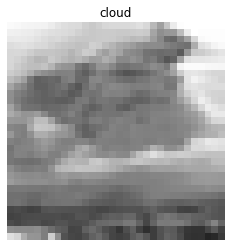

In [ ]:
# Plot
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

# Convert image type

In [ ]:
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape]) 
  return tf.cast(image, tf.float32), label

# Create input pipline using tf.data API , map() => batch => prefetch()

In [ ]:
import tensorflow as tf

In [ ]:
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

# Build model using feature extraction 

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False 

inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training=False) 
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) 

outputs = layers.Activation("softmax")(x) 
model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               128100    
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
Total params: 4,177,671
Trainable params: 128,100
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
history_feature_extract = model.fit(train_data, 
                                    epochs=5,
                                    steps_per_epoch=len(train_data),
                                    validation_data=test_data)

Epoch 1/5
1563/1563 [==============================] - 305s 191ms/step - loss: 1.6202 - accuracy: 0.5843 - val_loss: 1.2228 - val_accuracy: 0.6598
Epoch 2/5
1563/1563 [==============================] - 298s 191ms/step - loss: 1.0651 - accuracy: 0.6998 - val_loss: 1.1148 - val_accuracy: 0.6842
Epoch 3/5
1563/1563 [==============================] - 297s 190ms/step - loss: 0.9160 - accuracy: 0.7406 - val_loss: 1.0736 - val_accuracy: 0.6967
Epoch 4/5
1563/1563 [==============================] - 296s 189ms/step - loss: 0.8181 - accuracy: 0.7695 - val_loss: 1.0548 - val_accuracy: 0.7022
Epoch 5/5
1563/1563 [==============================] - 296s 189ms/step - loss: 0.7441 - accuracy: 0.7909 - val_loss: 1.0465 - val_accuracy: 0.7051


In [ ]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

313/313 [==============================] - 50s 158ms/step - loss: 1.0465 - accuracy: 0.7051


[1.0464568138122559, 0.7050999999046326]

# Plot loss curves

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

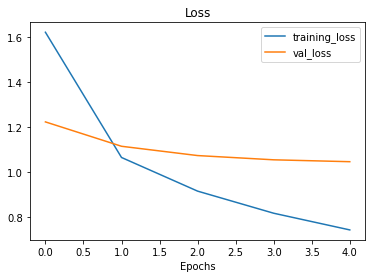

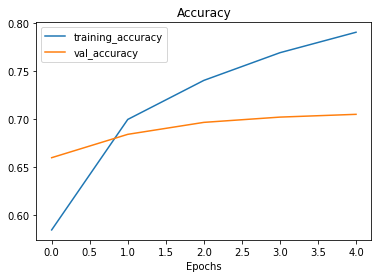

In [ ]:
plot_loss_curves(history_feature_extract)

# Build model using fine-tuning

In [ ]:
base_model.trainable = True

# Unfreeze last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False


In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

# Create early stopping callback and reduce learning rate callback

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)   # sau 3 epoch không cải thiện thì dừng

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # nhân với 0.2 (giảm 5 lần lr)
                                                 patience=2, 
                                                 verbose=1, 
                                                 min_lr=1e-7)

In [ ]:
# Compile and fit model

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(0.0001), 
              metrics=["accuracy"])

history_fine_tuning = model.fit(train_data, 
                                epochs=30,
                                steps_per_epoch=len(train_data),
                                validation_data=test_data,
                                callbacks=[early_stopping, reduce_lr])

Epoch 1/30
1563/1563 [==============================] - 320s 201ms/step - loss: 0.6078 - accuracy: 0.8237 - val_loss: 1.0072 - val_accuracy: 0.7201
Epoch 2/30
1563/1563 [==============================] - 312s 200ms/step - loss: 0.4857 - accuracy: 0.8626 - val_loss: 1.0121 - val_accuracy: 0.7274
Epoch 3/30
1563/1563 [==============================] - 312s 200ms/step - loss: 0.3959 - accuracy: 0.8913 - val_loss: 1.0334 - val_accuracy: 0.7288

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 4/30
1563/1563 [==============================] - 312s 200ms/step - loss: 0.2896 - accuracy: 0.9257 - val_loss: 1.0385 - val_accuracy: 0.7311


In [ ]:
results_fine_tuning_model = model.evaluate(test_data)
results_fine_tuning_model

313/313 [==============================] - 50s 159ms/step - loss: 1.0385 - accuracy: 0.7311


[1.0384526252746582, 0.7311000227928162]

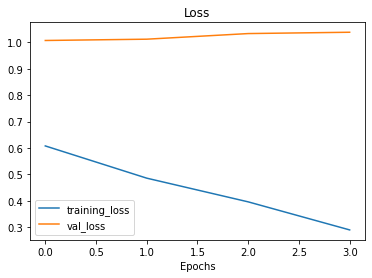

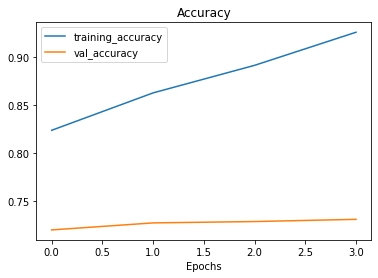

In [ ]:
plot_loss_curves(history_fine_tuning)

# Save model

In [119]:
model.save("/content/drive/MyDrive/Project/cifar101.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
